In [6]:
import scanpy as sc 
import pandas as pd
import SEACells
import numpy as np
import matplotlib
from statistics import mode
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
sys.path.insert(0, '../')
import utils
from importlib import reload
reload(utils)
from utils import *
# Some plotting aesthetics
%matplotlib inline
sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

data_path = "/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/Data/"
save_path_results = "/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/Results/"

In [13]:
adata = sc.read(data_path+'Neurips_Data.h5ad')
adata.X = adata.layers['counts']
adata.X.A

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]], dtype=uint16)

In [14]:
adata

AnnData object with n_obs × n_vars = 86233 × 18211
    obs: 'library_id', 'plate_name', 'well', 'row', 'col', 'cell_id', 'donor_id', 'cell_type', 'sm_lincs_id', 'sm_name', 'SMILES', 'dose_uM', 'timepoint_hr', 'control'
    layers: 'counts'

In [15]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
adata = adata[:, adata.var[(adata.var.mt == False) & (adata.var.ribo == False)].index.values]
adata

View of AnnData object with n_obs × n_vars = 86233 × 17934
    obs: 'library_id', 'plate_name', 'well', 'row', 'col', 'cell_id', 'donor_id', 'cell_type', 'sm_lincs_id', 'sm_name', 'SMILES', 'dose_uM', 'timepoint_hr', 'control'
    var: 'mt', 'ribo'
    layers: 'counts'

In [16]:
adata.obs.rename({"sm_name": "condition"}, axis=1, inplace=True)
adata.obs['condition'] = adata.obs['condition'].replace('Dimethyl Sulfoxide', 'control')

/tmp/ipykernel_1620327/3360995636.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['condition'] = adata.obs['condition'].replace('Dimethyl Sulfoxide', 'control')


In [17]:
adata.var.reset_index(inplace = True)
adata.var.rename({"gene": "gene_name"}, axis=1, inplace=True)
adata.var.set_index("gene_name", inplace = True)

In [18]:
from sklearn import preprocessing
adata.obs['cov_drug'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.condition.astype(str)
label_encoder = preprocessing.LabelEncoder()
adata.obs["condition_label"] = label_encoder.fit_transform(adata.obs["condition"])
num_perts = adata.obs["condition_label"].max()+1
print(adata.obs["condition"].unique())
print(adata.obs["condition_label"].unique())

['MLN 2238', 'Belinostat', 'Dabrafenib', 'control', 'Dactolisib', 'O-Demethylated Adapalene', 'R428', 'Porcn Inhibitor III']
Categories (8, object): ['Belinostat', 'Dabrafenib', 'Dactolisib', 'control', 'MLN 2238', 'O-Demethylated Adapalene', 'Porcn Inhibitor III', 'R428']
[3 0 1 7 2 4 6 5]


In [19]:
# basic qc and pp
adata.layers['counts'] = adata.X.copy()

# remove cells that have less than 1000 counts
sc.pp.filter_cells(adata, min_counts=1000, inplace =True)

# remove genes that are detected in less than 50 cells
sc.pp.filter_genes(adata, min_cells=50, inplace =True)

In [20]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 86230 × 17430
    obs: 'library_id', 'plate_name', 'well', 'row', 'col', 'cell_id', 'donor_id', 'cell_type', 'sm_lincs_id', 'condition', 'SMILES', 'dose_uM', 'timepoint_hr', 'control', 'cov_drug', 'condition_label', 'n_counts'
    var: 'mt', 'ribo', 'n_cells'
    uns: 'log1p'
    layers: 'counts'

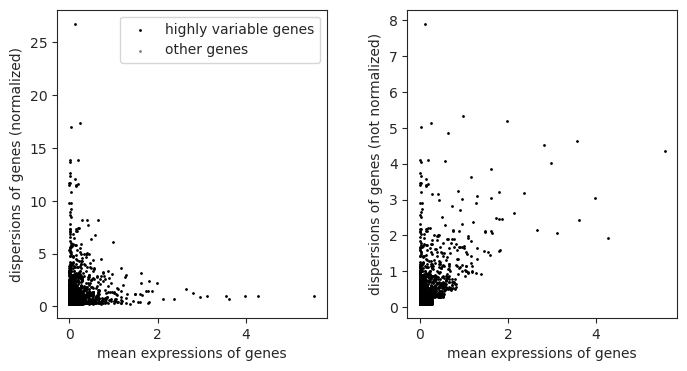

In [21]:
sc.pp.highly_variable_genes(adata, subset=True, n_top_genes = 5000)
sc.pl.highly_variable_genes(adata)

In [23]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alsulara/miniconda3/envs/Perturb

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


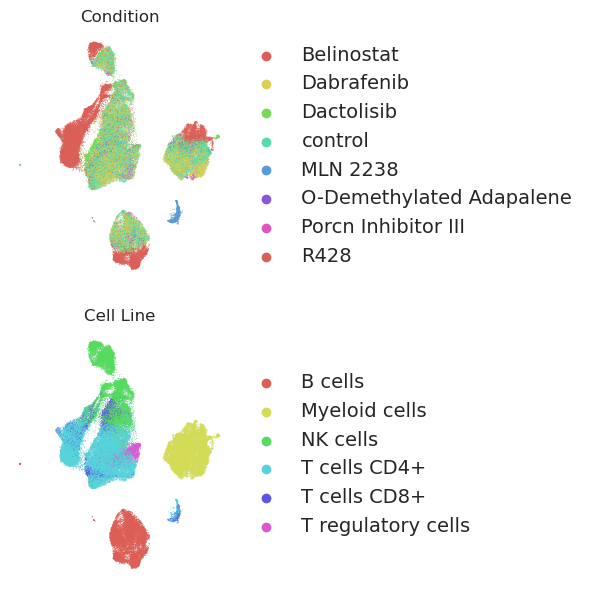

In [24]:
fig, axes = plt.subplots(nrows=2, figsize=(6, 6))  # Adjust figsize as needed
# Plot UMAP 1 in the first subplot if it's not empty
sc.pl.umap(adata=adata, color=["condition"],legend_fontsize=14,ax = axes[0],
           title = "Condition",
           show=False, palette = sns.color_palette("hls", 7),
           frameon=False)

sc.pl.umap(adata=adata, color=["cell_type"],legend_fontsize=14,ax = axes[1],
           title = "Cell Line",
           show=False, palette = sns.color_palette("hls", len(adata.obs.cell_type.unique())),
           frameon=False)

# Adjust spacing between subplots
plt.tight_layout()

# Show the merged plot
plt.savefig(save_path_results+'UMAP_Neurips.pdf', bbox_inches='tight')
plt.show()

In [25]:
ctrl_data = adata[adata.obs.condition == 'control'].copy()
ctrl_data

AnnData object with n_obs × n_vars = 28461 × 5000
    obs: 'library_id', 'plate_name', 'well', 'row', 'col', 'cell_id', 'donor_id', 'cell_type', 'sm_lincs_id', 'condition', 'SMILES', 'dose_uM', 'timepoint_hr', 'control', 'cov_drug', 'condition_label', 'n_counts'
    var: 'mt', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'condition_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [26]:
n_SEACells = int(len(ctrl_data) / 75)
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells
n_SEACells

379

In [27]:
model = SEACells.core.SEACells(ctrl_data, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [28]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/28461 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/28461 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/28461 [00:00<?, ?it/s]

Constructing CSR matrix...


In [29]:
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 360 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 29/29 [00:01<00:00, 18.13it/s]

Selecting 19 cells from greedy initialization.


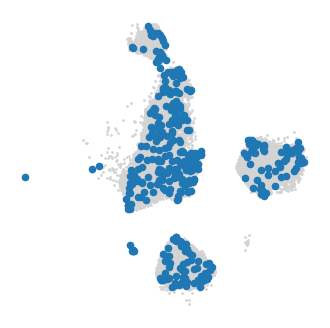

In [30]:
SEACells.plot.plot_initialization(ctrl_data, model)

In [31]:
model.fit(min_iter=10, max_iter=100)

Randomly initialized A matrix.
Setting convergence threshold at 0.00311
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 24 iterations.


In [32]:
# You can force the model to run additional iterations step-wise using the .step() function
print(f'Ran for {len(model.RSS_iters)} iterations')
for _ in range(5):
    model.step()
print(f'Ran for {len(model.RSS_iters)} iterations')

Ran for 25 iterations
Ran for 30 iterations


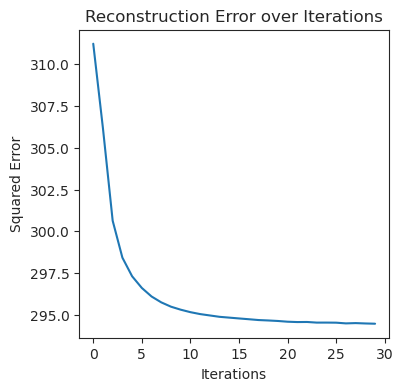

In [33]:
model.plot_convergence()

In [34]:
adata.obs['SEACell'] = 'None'
adata.obs.loc[ctrl_data.obs.index.tolist(), 'SEACell'] = ctrl_data.obs['SEACell'].values

In [35]:
SEACell_soft_ad = SEACells.core.summarize_by_soft_SEACell(ctrl_data,  model.A_, 
                                                          celltype_label='cell_type', summarize_layer = 'counts', minimum_weight = 0.05)
SEACell_soft_ad.X.A

100%|██████████| 379/379 [05:25<00:00,  1.16it/s]


array([[1.07853403e+00, 7.17091725e-02, 6.11152093e-02, ...,
        2.82972502e-03, 0.00000000e+00, 0.00000000e+00],
       [1.39062217e+00, 1.11597920e-02, 4.33483472e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.20211908e+00, 6.39736573e-02, 1.07980038e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.91881306e+00, 8.02042981e-02, 7.70513809e-02, ...,
        0.00000000e+00, 0.00000000e+00, 1.38676310e-02],
       [5.17750253e-01, 4.54913690e-02, 8.26376913e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.07647484e+00, 5.57565289e-02, 5.42549591e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [36]:
SEACell_soft_ad.obs
SEACell_soft_ad.obs.rename({"celltype": "cell_type"}, axis=1, inplace=True)
SEACell_soft_ad.obs.cell_type.value_counts()

cell_type
T cells CD4+          114
NK cells               90
Myeloid cells          73
B cells                70
T regulatory cells     27
T cells CD8+            5
Name: count, dtype: int64

In [37]:
adata = adata[adata.obs.condition != 'MLN 2238', :].copy()
crosstab_result = pd.crosstab(adata.obs['cell_type'], adata.obs['condition'])
display(crosstab_result)
SEACell_soft_ad.write(data_path+'SEACell_soft_ad_Neurips.h5ad')
adata.write(data_path+'Neurips_Data_Processed.h5ad')
adata

condition,Belinostat,Dabrafenib,Dactolisib,control,O-Demethylated Adapalene,Porcn Inhibitor III,R428
cell_type,,,,,,,
B cells,4167,3941,209,4399,255,282,220
Myeloid cells,2614,6143,87,5395,204,321,207
NK cells,3767,4962,299,5782,301,308,256
T cells CD4+,12152,9369,789,10778,599,880,598
T cells CD8+,1290,1281,55,1296,74,59,106
T regulatory cells,67,650,28,811,45,50,33


AnnData object with n_obs × n_vars = 85129 × 5000
    obs: 'library_id', 'plate_name', 'well', 'row', 'col', 'cell_id', 'donor_id', 'cell_type', 'sm_lincs_id', 'condition', 'SMILES', 'dose_uM', 'timepoint_hr', 'control', 'cov_drug', 'condition_label', 'n_counts', 'SEACell'
    var: 'mt', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'condition_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [7]:
SEACell_soft_ad = sc.read(data_path+'SEACell_soft_ad_Neurips.h5ad')
SEACell_soft_ad

AnnData object with n_obs × n_vars = 379 × 5000
    obs: 'Pseudo-sizes', 'cell_type', 'celltype_purity'

In [8]:
import os
import networkx as nx
from torch_geometric.utils.convert import from_networkx
from sklearn.metrics import mean_squared_error
from torch_geometric.data import InMemoryDataset, Data, download_url, extract_zip, HeteroData, Batch
from torch_geometric.utils import *
import torch
from torch import nn
cell_type_network = {}
# Leaf directory 
directory = "NeurIPS"
# Parent Directories 
parent_dir = "/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/graphs/"
# Path 
path = os.path.join(parent_dir, directory)
print(path)
try: 
    os.makedirs(path) 
except:
    print("File exists!")
max_nodes = 0
genes_pos = []
for cell_type in SEACell_soft_ad.obs.cell_type.unique():
    print(cell_type)
    cell = Correlation_matrix(SEACell_soft_ad, cell_type, 'cell_type',
                       hv_genes_cells = None, union_HVGs = True)
    threshold = np.percentile(np.abs(cell[0].values), 99.0)
    print("threshold:", threshold)
    g = create_coexpression_graph(SEACell_soft_ad, cell, cell_type, threshold, 'gene_name')
    if g.num_nodes >= max_nodes:
        max_nodes = g.num_nodes
    cell_type_network[cell_type] = g
    genes_pos.append(cell_type_network[cell_type].pos)
    cell_type_network[cell_type].pos = torch.tensor(cell_type_network[cell_type].pos)
    torch.save(cell_type_network[cell_type] , os.path.join(path,cell_type+'_coexpr_graph.pkl'))

cell_type_network

/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/graphs/NeurIPS
File exists!
NK cells


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.581719362231453
B cells


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.7458363741487182
Myeloid cells


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.6290200488495344
T cells CD4+


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.5239192511553525
T regulatory cells


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.6970437113459048
T cells CD8+


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.9779607627227829


{'NK cells': Data(x=[2925, 90], edge_index=[2, 122539], edge_attr=[122539], pos=[2925]),
 'B cells': Data(x=[2627, 70], edge_index=[2, 122564], edge_attr=[122564], pos=[2627]),
 'Myeloid cells': Data(x=[3268, 73], edge_index=[2, 122541], edge_attr=[122541], pos=[3268]),
 'T cells CD4+': Data(x=[2835, 114], edge_index=[2, 122526], edge_attr=[122526], pos=[2835]),
 'T regulatory cells': Data(x=[3932, 27], edge_index=[2, 122631], edge_attr=[122631], pos=[3932]),
 'T cells CD8+': Data(x=[4744, 5], edge_index=[2, 122628], edge_attr=[122628], pos=[4744])}

In [9]:
overlap_df = pd.DataFrame(index = cell_type_network.keys(), columns = cell_type_network.keys())
for key1 in cell_type_network.keys():
    for key2 in cell_type_network.keys():
        overlap_df.loc[key1, key2] = (len(np.intersect1d(cell_type_network[key1].pos, cell_type_network[key2].pos)))

# identify the furthest cell type
indices = np.argsort(overlap_df.values, axis=0)[-6, :]
print(indices)
testing_cell = overlap_df.columns[mode(indices)]
print(testing_cell)
overlap_df

[1 3 1 1 1 1]
B cells


,NK cells,B cells,Myeloid cells,T cells CD4+,T regulatory cells,T cells CD8+
NK cells,2925,1884,2250,2074,2356,2761
B cells,1884,2627,2017,1816,2132,2528
Myeloid cells,2250,2017,3268,2275,2599,3099
T cells CD4+,2074,1816,2275,2835,2265,2701
T regulatory cells,2356,2132,2599,2265,3932,3802
T cells CD8+,2761,2528,3099,2701,3802,4744


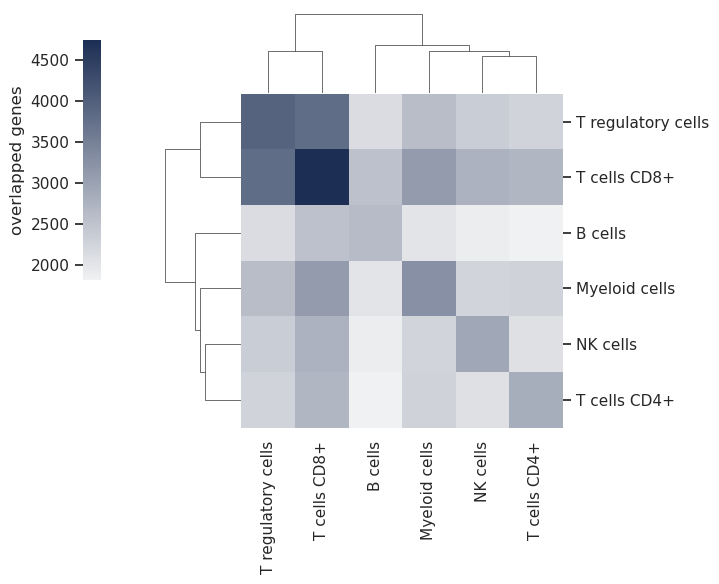

In [10]:
sns.set()
cmap = sns.light_palette("#1C2E54", as_cmap=True, n_colors = 5)
sns.set_style( {'axes.grid' : False})
g = sns.clustermap(overlap_df.astype(int), figsize=(6, 6), cmap = cmap
                   , cbar_kws={'label': 'overlapped genes', 'location': 'left'})
g.fig.subplots_adjust(right=0.7)
g.ax_cbar.set_position((-0.1, .52, .03, .4))
plt.savefig(save_path_results+'overlap_matrix_neurips.pdf', bbox_inches='tight')
plt.show()
sns.set()